# Topic Modelling with Gensim LDA

**LDA** - unsupervised Generative probabilistic machine learning technique used for extracting:
    
    1. number of topics in data (corpus)
    2. distribution of topics in each text(document)
    3. distribution of words(terms) in each topic
    
2 inputs: **dictionary** and **corpus**:
1. Dictionary - unique ids for each unique word.
2. corpus - number of times a particular word appears in each document number (document term matrix)

Document term matrix (N x M) -> converts into 2 lower dimensional matrices: document-topic matrix (alpha, M x K) and topic-term matrix (beta, K x N) where M is the number of documents, K is the number of topics and N is the vocabulary size.


LDA Input

1. M no of documents
2. N no of words
3. Hyper parameters $\alpha$ and $\beta$

LDA output
1. K no of topics (clusters of word)
2. Doc-topic distribution and topic-term distribution

* $\alpha$ - low means the document is represented by a few topics
* $\beta$ - low means the topic contains a mix of a few words

**Creating a base model**: we need to define
* k, the number of topics. `num_topics`
* also tune the hyperparameters alpha and beta
* chunk size of documents in each training chunk, increading chunk size speeds up training (but at what cost????)
* update_every determines how often model parameters are updated

## Topic Coherence
how good is a given topic model? Topic coherence measures the average similarity between top words having the highest weights in a topic i.e. relative distance between topic words

Coherence is improved by building different LDA models at various values of k, and picking the model that gives the highest coherence value. (just like clustering!!!!)

**Using topic and description and transcript**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
import re
import nltk
import spacy
import en_core_web_sm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel




In [ ]:
%pip install pyLDAvis
%pip install nlp
# %%python -m spacy download en_core_web_sm
import pyLDAvis
import nlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 30.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.
tensorflow 2.12.0 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.2 MB/s eta 0:00:00


In [ ]:
# re-import cleaned data and merge talk and description into one file
url = "/content/drive/MyDrive/TED_Project/ted_talk_clean.csv"

def clean_data(url=url):

    # data_cleaned = pd.read_csv('../Data_output/ted_talk_clean.csv')
    data_cleaned = pd.read_csv(url)
    data_cleaned['descr'] = data_cleaned['talk'] + \
                            data_cleaned['description'] + \
                            data_cleaned['transcript']
    data_cleaned['descr'].head()

    # preprocessing data

    # convert to list
    data = data_cleaned['descr'].values.tolist()
    # remove emails
    data = [re.sub('\S*@\S*\s?', '', i) for i in data]
    # remove new line characters
    data = [re.sub('\s+', ' ', i) for i in data]
    # remove distracting single quotes
    data = [re.sub("\'", "", i) for i in data]
    return data

# breaking sentences into a list of words and cleaning up messy text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        # yield is the return function for a generator


def remove_stopwords(texts):
    from nltk.corpus import stopwords
    try:
        stop_words = stopwords.words('english')
    except:
        print('failed')
        stop_words = nltk.download('stopwords')
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):

    import en_core_web_sm
    nlp = spacy.load("en_core_web_sm")
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:18: DeprecationWarning: invalid escape sequence '\S'
<>:20: DeprecationWarning: invalid escape sequence '\s'
<>:18: DeprecationWarning: invalid escape sequence '\S'
<>:20: DeprecationWarning: invalid escape sequence '\s'
<ipython-input-4-ad3f484d099c>:18: DeprecationWarning: invalid escape sequence '\S'
  data = [re.sub('\S*@\S*\s?', '', i) for i in data]
<ipython-input-4-ad3f484d099c>:20: DeprecationWarning: invalid escape sequence '\s'
  data = [re.sub('\s+', ' ', i) for i in data]


In [ ]:
data = clean_data(url)
data_words = list(sent_to_words(data))
# remove stop words
data_words_nostops = remove_stopwords(data_words)
# do lemmetization keeping only nouns
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN'])
len(data_words_nostops[0]), len(data_words[0]), len(data_lemmatized[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(962, 1853, 411)

# Creating LDA Model

## Creating LDA inputs

In [ ]:
def create_corpus_dictionary(data_lemmatized):
    texts = data_lemmatized
    # create dictionary
    id2word = corpora.Dictionary(texts)
    # corpus
    texts = data_lemmatized
    # term document frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    return corpus, id2word

# create LDA inputs
corpus, id2word = create_corpus_dictionary(data_lemmatized)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
temp_file = "/content/drive/MyDrive/TED_Project/output_6/dictionary"
id2word.save(temp_file)
import pickle
with open("/content/drive/MyDrive/TED_Project/output_6/corpus.pkl", 'wb') as f:
    pickle.dump(corpus, f)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## hyperparameter tuning

### Hyperparameter tuning: topics

In [ ]:
def compute_and_plot_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    compute c_v coherence for various number of topics
    parameters:
    dictionary: gensim dictionary
    corpus: gensim corpus
    texts: list of input texts
    limit: max num of topics

    returns:
    model_list: list of LDA topic models
    coherence_values: coherence values corresponding to the LDA model with respective number of topics
    """

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               num_topics=num_topics,
                                               random_state=100,
                                               chunksize=200,
                                               passes=10,
                                               alpha=0.91,
                                               eta=0.91,
                                               per_word_topics=True,
                                               id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                       texts=texts,
                                       dictionary=dictionary,
                                       coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    # show graph
    import matplotlib.pyplot as plt
    x = range(start, limit, step)
    plt.figure(figsize=(20,20))
    plt.plot(x, coherence_values)
    plt.grid()
    plt.xticks(x)
    plt.xlabel('Num Topics')
    plt.ylabel('Coherence Score')
    plt.legend(('coherence_values'), loc='best')
    plt.show()

    return model_list, coherence_values



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### hyperparameter tuning the alpha, beta and other values

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=k,
                                               random_state=100,
                                               chunksize=200,
                                               passes=10,
                                               alpha=a,
                                               eta=b,
                                               per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                        texts=data_lemmatized,
                                        dictionary=id2word,
                                        coherence='c_v')

    return coherence_model_lda.get_coherence()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Visualizing the Topics

## pyLDAvis & Word Cloud

In [ ]:
def pyldavisualize_lda(lda_model_final, google_colab=True):
    """visualize the topics/keywords using pyLDAvis"""
    import pyLDAvis
    if google_colab: # work around for google colab
        %pip install pandas==1.5.3 # hack for google colab only
        import pyLDAvis.gensim_models as gensimvis # gensim_models for google colab
    else:
        import pyLDAvis.gensim as gensimvis
    pyLDAvis.enable_notebook()

    # feed the LDA model into the pyLDAvis instance
    lda_viz = gensimvis.prepare(lda_model_final, corpus, id2word)
    return lda_viz

def word_cloud_visualizer(lda_model_final, num_topics, display_topics=False):
    """word cloud of top N words proportional to their weights"""
    import wordcloud
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.colors as mcolors
    import math
    # generate colors
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] + [color for name, color in mcolors.XKCD_COLORS.items()]
    # generate cloud
    cloud = WordCloud(stopwords = STOPWORDS,
                    background_color = 'white',
                    width=2500,
                    height=2800,
                    max_words=15,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs:cols[i],
                    prefer_horizontal=1.0)

    # get topics
    topics=lda_model_final.show_topics(num_topics=num_topics, formatted=False)
    # optional print topics
    if display_topics:
        print(topics)

    ######### plot word cloud ############
    # get row and col dimensions
    num_row_col = math.ceil(math.sqrt(num_topics))

    fig, axes = plt.subplots(num_row_col, num_row_col, figsize=(20,20),
                        sharex=True,
                        sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
        if i==num_topics:
            break

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()
    return cloud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# More alpha and beta hyperparameter tuning
**num_topics == 11** is giving the best results.
alpha and beta hyperparameter tuning...

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_set'] ={}

# topics range
topics_range = range(6,7,11)

# alpha parameter
alpha = list(np.arange(0.01, 1, 0.15))
alpha.append('symmetric')
alpha.append('asymmetric')

# beta parameter
beta = list(np.arange(0.01, 1, 0.15))
beta.append('symmetric')

# validation sets
num_of_docs = len(corpus)
# corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
#               corpus]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_sets = [corpus]


corpus_title = ['100% Corpus']
model_results = {
                'Validation_Set': [],
                'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

pbar = tqdm.tqdm(total=250)

for i in range(len(corpus_sets)):
    # itearte through the number of topics
    for k in topics_range:
        # iterate through the alpha values
        for a in alpha:
            # iterate through the beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus_sets[i],
                                             dictionary=id2word,
                                             k=k,
                                             a=a,
                                             b=b)
                # save the model results
                model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)

                pbar.update(1)
pbar.close()


lda_tuning_results = pd.DataFrame(model_results)
print("\nMaximum coherence is: ",max(lda_tuning_results['Coherence']))
lda_tuning_results.iloc[lda_tuning_results['Coherence'].idxmax()]

In [ ]:
print("\nMaximum coherence is: ",max(lda_tuning_results['Coherence']))
lda_tuning_results.iloc[lda_tuning_results['Coherence'].idxmax()]


Maximum coherence is:  0.4273600678302751


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Validation_Set    100% Corpus
Topics                      6
Alpha                    0.46
Beta                     0.61
Coherence             0.42736
Name: 28, dtype: object

In [ ]:
# Final LDA model

for num_topics in [6]:
    lda_mod = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                 id2word=id2word,
                                                 num_topics=num_topics,
                                                 random_state=100,
                                                 chunksize=200,
                                                 passes=10,
                                                 alpha=0.46,
                                                 eta=0.61,
                                                 per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_mod,
                                        texts=data_lemmatized,
                                        dictionary=id2word,
                                        coherence='c_v')
    print("\n\n==============================\nNum Topics:", num_topics)
    print("Coherence Score:", coherence_model_lda.get_coherence())
    print(" ")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




Num Topics: 6
Coherence Score: 0.4273600678302751
 


## Saving Model with 6 topics

In [ ]:
temp_file = "/content/drive/MyDrive/TED_Project/output_6/model"
lda_mod.save(temp_file)

# Load a potentially pretrained model from disk.
lda_mod = gensim.models.ldamodel.LdaModel.load(temp_file)

pyLDAvis.save_html(pyldavisualize_lda(lda_mod), '/content/drive/MyDrive/TED_Project/output_6/lda.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.077488 -0.112440       1        1  27.941313
5     -0.065416 -0.077267       2        1  27.370513
4     -0.197964  0.061255       3        1  13.725083
1      0.139003 -0.100229       4        1  11.478327
0      0.171681  0.038082       5        1  10.418617
3      0.030185  0.190599       6        1   9.066148, topic_info=          Term          Freq         Total Category  logprob  loglift
244      woman   7722.000000   7722.000000  Default  30.0000  30.0000
122   laughter  16190.000000  16190.000000  Default  29.0000  29.0000
638      brain   5632.000000   5632.000000  Default  28.0000  28.0000
889      water   4923.000000   4923.000000  Default  27.0000  27.0000
158     people  35758.000000  35758.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1395  research    670.866527   2114.908299   Topic6  -5.5328   1.2524
129       life    807.875302  12576.090806   Topic6  -5.3469  -0.3445
239        way    808.577013  17895.740344   Topic6  -5.3460  -0.6964
476    percent    731.215024   6929.245198   Topic6  -5.4466   0.1518
38       child    643.090292   7667.819594   Topic6  -5.5750  -0.0779

[482 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2576      1  0.003451  abuse
2576      2  0.079373  abuse
2576      3  0.883458  abuse
2576      4  0.003451  abuse
2576      5  0.003451  abuse
...     ...       ...    ...
246       2  0.337927   year
246       3  0.153011   year
246       4  0.076589   year
246       5  0.135088   year
246       6  0.055844   year

[2288 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 5, 2, 1, 4])

IndexError: ignored

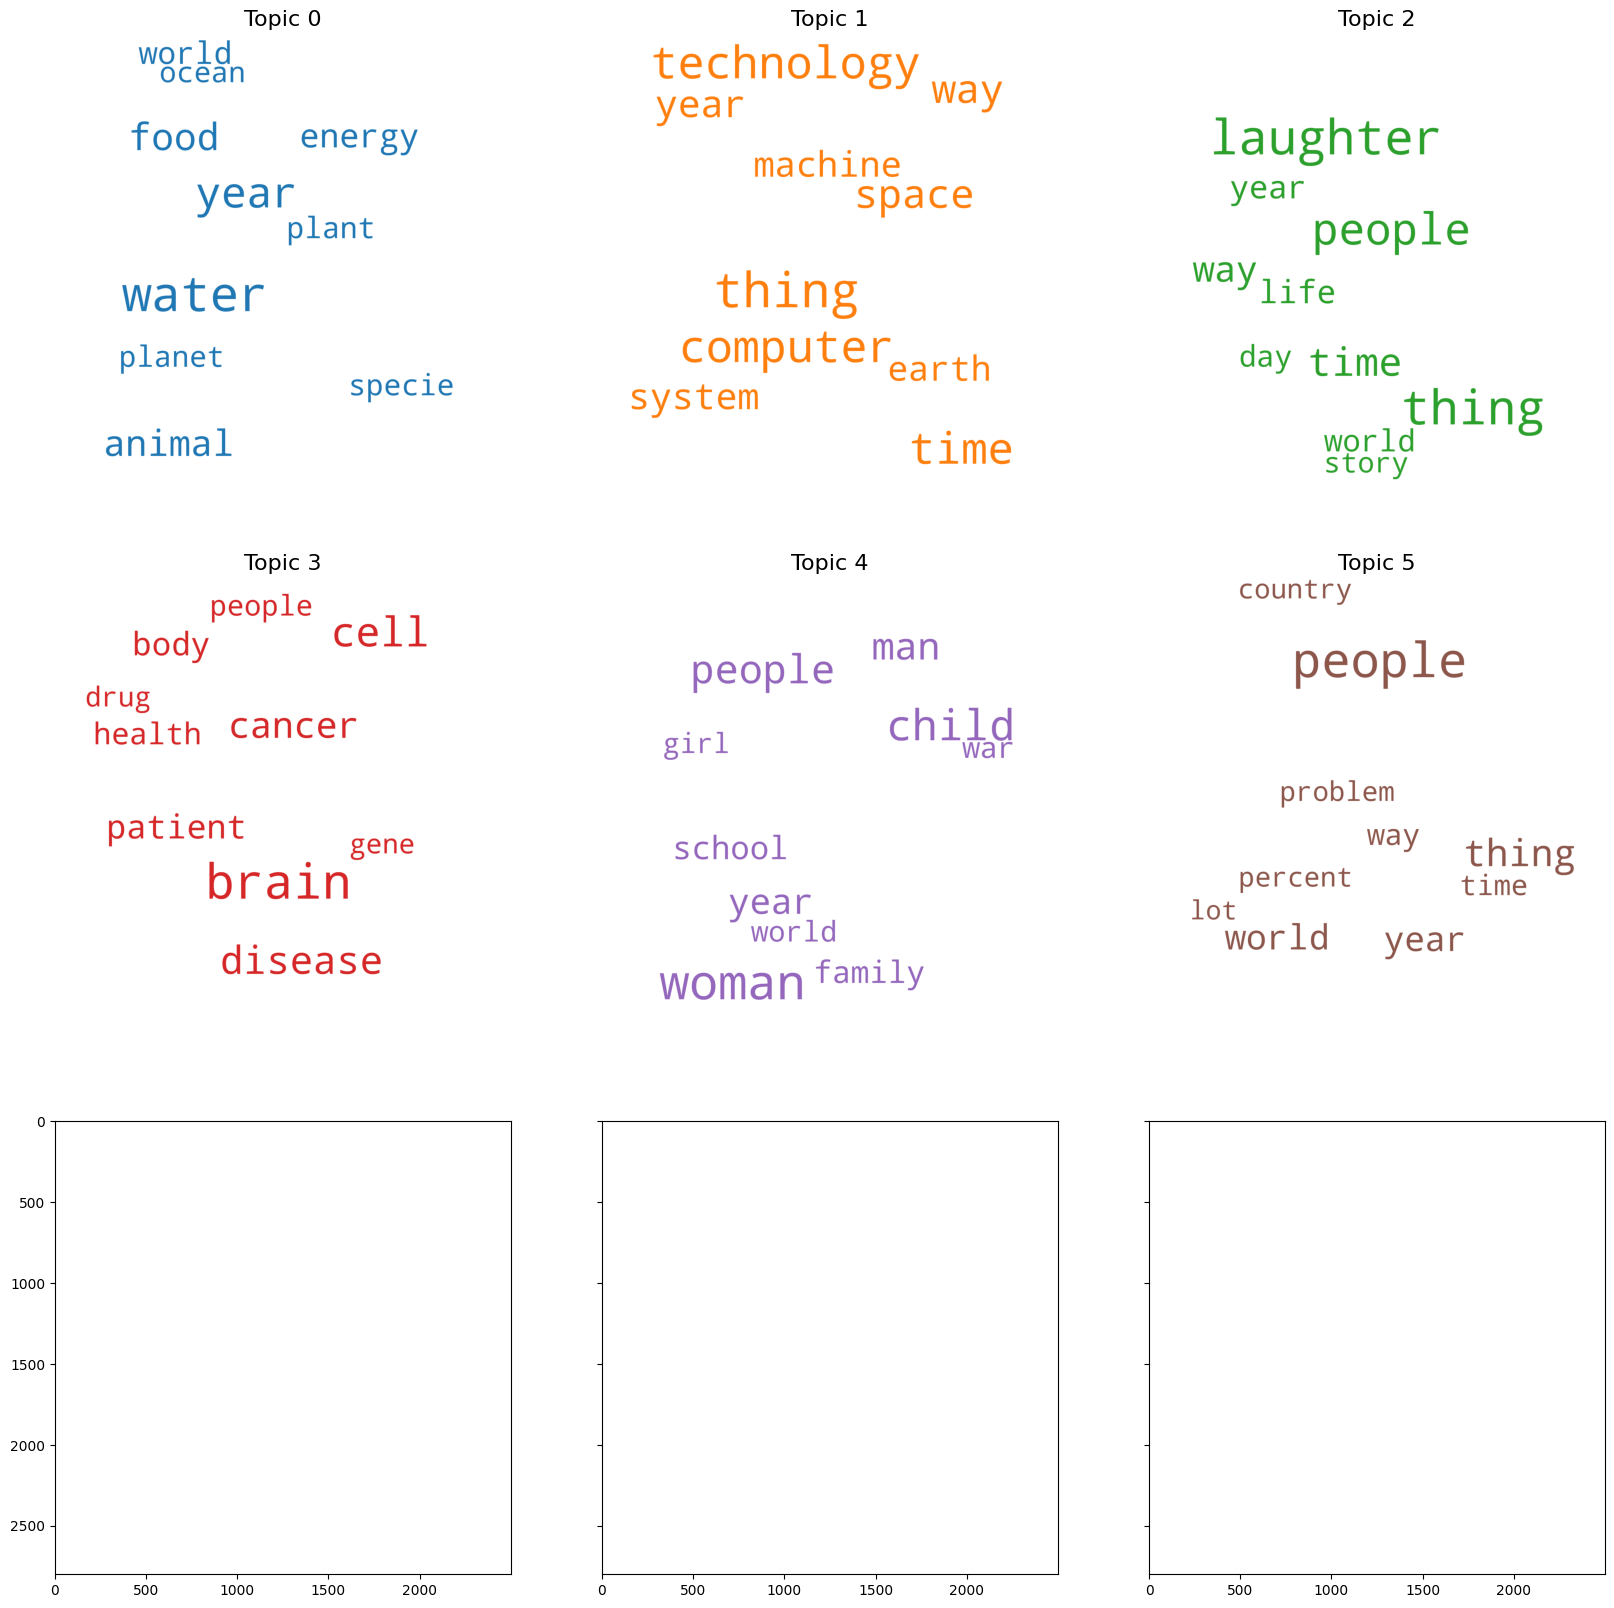

In [ ]:
pyvis = pyldavisualize_lda(lda_mod)
display(pyvis)
pyLDAvis.save_html(pyvis, 'lda.html')
word_cloud_visualizer(lda_mod, num_topics)